# TP4: More Transformers

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from torch.utils.tensorboard import SummaryWriter


# Write the attention mechanism
Write purely functional module that will be used in both decoders and encoders.


In [33]:
class Attention(nn.Module):
    def __init__(self, h=1):
        super().__init__()
        self.h = h

    def forward(self, Q, K, V, mask=None):
        # Q: (b, T, d)
        # K: (b, Tk, d)
        # V: (b, Tk, dv)
        # Output: (b, T, dv)
        b, T, d = Q.shape
        _, Tk, _ = K.shape
        _, _, dv = V.shape
        h = self.h

        Q = Q.view(b, T, h, d // h).transpose(1, 2)
        K = K.view(b, Tk, h, d // h).transpose(1, 2)
        V = V.view(b, Tk, h, dv // h).transpose(1, 2)

        scores = Q @ K.transpose(-1, -2) / math.sqrt(d // h)  # (b, h, T, Tk)
        if mask is not None:
            mask = mask.unsqueeze(0).unsqueeze(0)  # (1, 1, T, Tk)
            scores = scores.masked_fill(mask == 0, float("-inf"))
        attn = torch.softmax(scores, dim=-1)  # b, h, T, Tk
        output = attn @ V  # b, h, T, dv // h
        return output.transpose(1, 2).reshape(b, T, dv)


class AttentionLayer(nn.Module):
    def __init__(self, h=4, dk=16, dv=16):
        super().__init__()
        self.to_keys = nn.Linear(dk, dk)
        self.to_queries = nn.Linear(dk, dk)
        self.to_values = nn.Linear(dk, dv)

        self.attention = Attention(h=h)
        self.unifyhead = nn.Linear(dv, dv)

    def forward(self, x, context=None, mask=None):
        if context is None:
            context = x
        Q = self.to_queries(x)
        K = self.to_keys(context)
        V = self.to_values(context)
        out = self.attention(Q, K, V, mask=mask)
        return self.unifyhead(out)


Q = torch.randn(2, 5, 16)
K = torch.randn(2, 7, 16)
V = torch.randn(2, 7, 8)


mhattn = Attention(h=4)
out2 = mhattn(Q, K, V)

# Write the encoder and decoder blocks
See diagram for architectures.

In [11]:
class EncoderBlock(nn.Module):
    def __init__(self, dk, heads):
        super().__init__()

        self.self_attention = AttentionLayer(heads, dk, dk)
        self.norm1 = nn.LayerNorm(dk)
        self.norm2 = nn.LayerNorm(dk)
        self.ff = nn.Sequential(nn.Linear(dk, 4 * dk), nn.GELU(), nn.Linear(4 * dk, dk))

    # def forward(self, x):
    #     x = self.norm1(x + self.self_attention(x))  # residual connection
    #     return self.norm2(x + self.ff(x))

    def forward(self, x):
        x = x + self.self_attention(self.norm1(x))  # residual connection
        return x + self.ff(self.norm2(x))


class DecoderBlock(nn.Module):
    def __init__(self, dk, heads):
        super().__init__()

        self.self_attention = AttentionLayer(heads, dk, dk)
        self.cross_attention = AttentionLayer(heads, dk, dk)
        self.norm1 = nn.LayerNorm(dk)
        self.norm2 = nn.LayerNorm(dk)
        self.norm3 = nn.LayerNorm(dk)
        self.ff = nn.Sequential(nn.Linear(dk, 4 * dk), nn.GELU(), nn.Linear(4 * dk, dk))

    # def forward(self, x, context, mask=None):
    #     x = self.norm1(x + self.self_attention(x, mask=mask))
    #     x = self.norm2(x + self.cross_attention(x, context=context))
    #     return self.norm3(x + self.ff(x))

    def forward(self, x, context, mask=None):
        x = x + self.self_attention(self.norm1(x), mask=mask)
        x = x + self.cross_attention(self.norm2(x), context=context)
        return x + self.ff(self.norm3(x))


class PositionalEncoding(nn.Module):
    def __init__(self, d, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d, 2) * (-math.log(10000.0) / d))
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1, max_len, d)

    def forward(self, x):
        # x: b, T, d
        return self.pe[:, : x.shape[1], :]


# Invert words: build a dataset

In the next cells, we will build a dataset where the target sequence is the input 
sequence with words in reverse order. The vocabulary is made of the 10k frequent French words.

We add three special tokens: 
- "START" at the beginning of the sequence
- "END" at the end of the sequence
- "PAD" to pad sequences to the same length in a batch




In [34]:
with open("data/words.txt", "r") as f:
    text = f.read()
    words = text.splitlines()

words = [w for w in words if len(w) > 2]

# build vocab over characters only

chars = sorted(list(set(text))) + ["START", "END", "PAD"]
vocab_size = len(chars)

stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}


def string2idx(s):
    s = ["START"] + list(s) + ["END"]
    return torch.tensor([stoi[c] for c in s], dtype=torch.long)


def idx2string(t):
    end_token = stoi["END"]
    s_list = []
    for i in range(len(t)):
        s_list.append(itos[t[i].item()])
        if t[i] == end_token:
            break
    return "".join(s_list[1:-1])


print(f"Vocab size: {vocab_size}")
print(f"Number of words in dictionary {len(words)}")
print("Max word length:", max([len(w) for w in words]))

print("Example:")
print(f"{string2idx('hello')=}")
print(f"{idx2string(string2idx('hello'))=}")

Vocab size: 262
Number of words in dictionary 98743
Max word length: 21
Example:
string2idx('hello')=tensor([259,  22,  19,  26,  26,  29, 260])
idx2string(string2idx('hello'))='hello'


To pad a batch of sequences, we will use the pad_sequence function from torch.nn.utils.rnn. 
It takes as input a list of sequences (1D tensors) and returns a 2D tensor of shape (max_seq_len, batch_size).

Looking at the Transformers diagram, think of how to build the input and target sequences for the decoder. 


In [304]:
pad_fn = nn.utils.rnn.pad_sequence


def get_batch(words, batch_size=32):
    """
    encoder_inputs :  'START' h e l l o 'END'
    decoder_inputs  : 'START' o l l e h
    targets :            o    l l e h 'END'
    """
    enc_inputs, targets = [], []

    for _ in range(batch_size):
        w = np.random.choice(words)
        idx = string2idx(w)

        end = idx[-1].unsqueeze(0)
        inner = torch.flip(idx[1:-1], dims=[0])
        winv = torch.cat([inner, end])

        enc_inputs.append(idx)
        targets.append(winv)

    enc_inputs = pad_fn(enc_inputs, batch_first=True, padding_value=stoi["PAD"])
    # (b, T_in)
    targets = pad_fn(targets, batch_first=True, padding_value=stoi["PAD"])  # (b, T_out)
    dec_inputs = torch.cat(
        [
            torch.full((targets.size(0), 1), stoi["START"], dtype=torch.long),
            targets[:, :-1],
        ],
        dim=1,
    )  # (b, T_out)
    return enc_inputs, dec_inputs, targets


print(get_batch(words, 2))


(tensor([[259,  17,  29,  28,  34,  19,  27,  30,  26,  15,  34,  23,  29,  28,
          33, 260],
        [259,  27,  23,  17,  15,  22, 260, 261, 261, 261, 261, 261, 261, 261,
         261, 261]]), tensor([[259,  33,  28,  29,  23,  34,  15,  26,  30,  27,  19,  34,  28,  29,
          17],
        [259,  22,  15,  17,  23,  27, 260, 261, 261, 261, 261, 261, 261, 261,
         261]]), tensor([[ 33,  28,  29,  23,  34,  15,  26,  30,  27,  19,  34,  28,  29,  17,
         260],
        [ 22,  15,  17,  23,  27, 260, 261, 261, 261, 261, 261, 261, 261, 261,
         261]]))


# Build the model

In [35]:
class Transformer(nn.Module):
    def __init__(
        self,
        d,
        heads,
        n_layers,
        vocab_in,
        vocab_out,
        block_size_in,
        block_size_out,
        device=None,
    ):
        super().__init__()
        self.vocab_out = vocab_out
        self.pe_enc = PositionalEncoding(d, block_size_in)
        self.pe_dec = PositionalEncoding(d, block_size_out)

        self.emb_enc = nn.Embedding(vocab_in, d)
        self.encoder = nn.Sequential(*[EncoderBlock(d, heads) for _ in range(n_layers)])

        self.embed_target = nn.Embedding(vocab_out, d)
        self.decoder = nn.ModuleList([DecoderBlock(d, heads) for _ in range(n_layers)])
        self.ln_f = nn.LayerNorm(d)
        self.prediction_head = nn.Linear(d, vocab_out)

        self.start_token = stoi["START"]
        self.pad_token = stoi["PAD"]
        self.device = device if device is not None else torch.device("cpu")

    @torch.no_grad()
    def generate(self, context_idx, max_len):
        # context_idx: b, Tin
        # Output: b, max_len
        b, Tin = context_idx.shape
        context = self.emb_enc(context_idx)
        context = context + self.pe_enc(context)
        context = self.encoder(context)

        idx = torch.zeros((b, 1), dtype=torch.long, device=self.device)
        idx[:, 0] = self.start_token  # b, 1

        for _ in range(max_len):
            x = self.embed_target(idx)
            x = x + self.pe_dec(x)
            for layer in self.decoder:
                x = layer(x, context)
            logits = self.prediction_head(self.ln_f(x))  # b, t, vocab_out
            next_token = torch.argmax(logits[:, -1, :], dim=-1, keepdim=True)  # b, 1
            idx = torch.cat([idx, next_token], dim=1)  # b, t+1
        return idx

    def forward(self, context_idx, idx, targets=None):
        B, Tin = context_idx.shape
        _, Tout = idx.shape

        # encode context
        context = self.emb_enc(context_idx)
        context = context + self.pe_enc(context)
        context = self.encoder(context)

        # decode idx
        x = self.embed_target(idx)
        x = x + self.pe_dec(x)
        mask = torch.tril(torch.ones((Tout, Tout), device=self.device))
        for layer in self.decoder:
            x = layer(x, context, mask=mask)

        logits = self.prediction_head(self.ln_f(x))

        # compute loss
        if targets is None:
            return logits, None
        loss = F.cross_entropy(
            logits.view(-1, logits.shape[-1]),
            targets.view(-1),
            ignore_index=self.pad_token,
        )

        return logits, loss

# Run the training loop

In [36]:
model = Transformer(
    d=128,
    heads=4,
    n_layers=2,
    vocab_in=vocab_size,
    vocab_out=vocab_size,
    block_size_in=23,
    block_size_out=23,
)

batch_size = 32

optimizer = optim.Adam(model.parameters(), lr=1e-3)

losses = []
test_strings = ["bonjour", "abc"]
for i in range(2000):
    context_idx, idx, targets = get_batch(words, batch_size=batch_size)
    logits, loss = model(context_idx, idx, targets=targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if i % 100 == 0:
        for s in test_strings:
            context_idx = string2idx(s).unsqueeze(0)
            print(f"String to invert : {s}")
            print(f"Output : {idx2string(model.generate(context_idx, 20)[0])}")
            print(loss.item())


NameError: name 'get_batch' is not defined

In [ ]:
context = string2idx("bonjour").unsqueeze(0)
print(f"context : {context[0]}")
print(f"output : {idx2string(model.generate(context, 20)[0])}")

context = string2idx("hello").unsqueeze(0)
print(f"context : {context[0]}")
print(f"output : {idx2string(model.generate(context, 20)[0])}")

context : tensor([259,  16,  29,  28,  24,  29,  35,  32, 260])
output : erererere
context : tensor([259,  22,  19,  26,  26,  29, 260])
output : eererere


# Vision Transformers

In [4]:
# Load CIFAR10 dataset and define a transformation done on all images:
# - resize to 32x32 (does nothing here)
# - convert to tensor
# - normalize to mean 0.5, std 0.5 for each channel
transform = transforms.Compose(
    [transforms.Resize(32), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
trainset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
testset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

print(f"Train points {len(trainset)}")
print(f"Test points {len(testset)}")

Files already downloaded and verified
Files already downloaded and verified
Train points 50000
Test points 10000


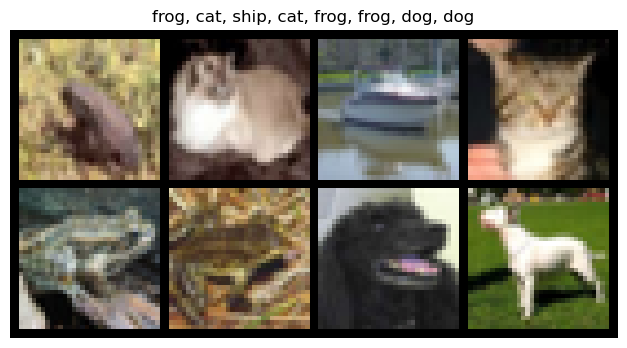

Number of classes: 10
Image shape: torch.Size([3, 32, 32])


In [37]:
# trainset = datasets.CIFAR10(
#     root="./data", train=True, download=True, transform=transform
# show a few images from the training loader
train_dl = DataLoader(trainset, batch_size=8, shuffle=True)
imgs, labels = next(iter(train_dl))
imgs = imgs[:8] * 0.5 + 0.5  # pick first 8
# denormalize (Normalize was mean=0.5, std=0.5)
grid = make_grid(imgs, nrow=4)

plt.figure(figsize=(8, 4))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis("off")
plt.title(", ".join([trainset.classes[int(ell)] for ell in labels[:8]]))
plt.show()

print(f"Number of classes: {len(trainset.classes)}")
# print(f"Classes: {trainset.classes}")
print(f"Image shape: {imgs[0].shape}")  # C, H, W

Using `unfold' to make patches


In [ ]:
x = torch.tensor([[1, 2, 3, 4, 5]])
y = x.unfold(dimension=1, size=3, step=1)
print(y)
print(y.shape)

img = torch.arange(16).view(4, 4)
print(f"{img=}")
print(img.unfold(0, 2, 2).unfold(1, 2, 2))  # (2, 2, 2, 2)

# Build a Vision Transformer model

Use the unfold function to create patches from images.
Flatten the patches and project them to a higher dimension using a linear layer.



In [21]:
class ViT(nn.Module):
    def __init__(
        self,
        image_size=32,
        patch_size=4,
        d=128,
        depth=4,
        heads=4,
        num_classes=10,
        n_channels=3,
    ):
        super().__init__()
        assert image_size % patch_size == 0
        n_patches = (image_size // patch_size) ** 2
        patch_dim = n_channels * patch_size * patch_size

        self.patch_embed = nn.Linear(patch_dim, d)
        self.pos_enc = PositionalEncoding(d, n_patches + 1)

        self.cls_token = nn.Parameter(torch.randn(1, 1, d))
        self.encoder = nn.Sequential(*[EncoderBlock(d, heads) for _ in range(depth)])
        self.mlp_head = nn.Sequential(nn.LayerNorm(d), nn.Linear(d, num_classes))

        self.patch_size = patch_size

    def forward(self, x):
        B, C, H, W = x.shape
        p = self.patch_size
        nH, nW = H // p, W // p
        n_patches = nH * nW
        x = x.unfold(2, p, p).unfold(3, p, p)  # (B, C, nH, nW, p, p)
        # flatten patches
        x = x.permute(0, 2, 3, 1, 4, 5)  # (B, nH, nW, C, p, p)
        x = x.reshape(B, n_patches, C * p * p)  # (B, C, n_patches, patch_dim)
        # x : (B, n_patches, patch_dim)
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_enc(x)
        x = self.encoder(x)  # b, n_patches + 1, d
        # use the cls token output for classification
        return self.mlp_head(x[:, 0])

# Run the training loop

Use 
[tensorboard]
( https://docs.pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) 
to monitor training.


In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViT().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

train_dl = DataLoader(trainset, batch_size=8, shuffle=True)
test_dl = DataLoader(testset, batch_size=4)

writer = SummaryWriter("runs/vit_cifar_experiment")

# log a small batch of images and the model graph (if possible)
imgs_sample, labels_sample = next(iter(train_dl))
imgs_sample = imgs_sample.to(device)
# writer.add_graph(model, imgs_sample)  # may fail for some models
grid = make_grid(imgs_sample[:16], nrow=4, normalize=True, scale_each=True)
writer.add_image("train/sample_images", grid)

In [26]:
def test_model(model, test_dl, writer=None, global_step=None):
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in test_dl:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs).argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    if writer is not None and global_step is not None:
        writer.add_scalar("test/accuracy", 100 * correct / total, global_step)
    print(f"Test accuracy: {100 * correct / total:.2f}%")

In [27]:
# provide a global step counter that you can increment in the training loop if desired
global_step = 0

train_dl = DataLoader(trainset, batch_size=32, shuffle=True)

test_model(model, test_dl, writer, 0)
for epoch in range(5):
    for imgs, labels in train_dl:
        global_step += 1
        imgs, labels = imgs.to(device), labels.to(device)
        opt.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        writer.add_scalar("train/loss", loss.item(), global_step)
        loss.backward()
        opt.step()
    print(f"Epoch {epoch + 1}: train loss = {loss.item():.4f}")
    test_model(model, test_dl, writer, global_step)


Test accuracy: 17.60%
Epoch 1: train loss = 1.7267
Test accuracy: 49.14%
Epoch 2: train loss = 0.8592
Test accuracy: 53.88%
Epoch 3: train loss = 0.8030
Test accuracy: 58.11%


KeyboardInterrupt: 

# Compare with a CNN

Implement a simple CNN and compare its performance with the Vision Transformer on CIFAR10.
The architecture can be as follows:
- a conv layer with 32 filters, kernel size 3, stride 1, padding 1, followed by ReLU and max-pooling
- a conv layer with 64 filters, kernel size 3, stride 1, padding 1, followed by ReLU and max-pooling
- a fully connected layer with 128 units, followed by ReLU
- a final fully connected layer with 10 units (one per class)

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),  # -> 32xHxW
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [31]:
cnn = SimpleCNN().to(device)
total_params = sum(p.numel() for p in cnn.parameters())
print("Training SimpleCNN model with {total_params} parameters")

train_dl = DataLoader(trainset, batch_size=32, shuffle=True)
opt = torch.optim.Adam(cnn.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

for epoch in range(5):
    for imgs, labels in train_dl:
        global_step += 1
        imgs, labels = imgs.to(device), labels.to(device)
        opt.zero_grad()
        logits = cnn(imgs)
        loss = criterion(logits, labels)
        writer.add_scalar("train/cnn_loss", loss.item(), global_step)
        loss.backward()
        opt.step()
    print(f"Epoch {epoch + 1}: train loss = {loss.item():.4f}")
    test_model(model, test_dl, writer=None, global_step=None)


Total params: 545098
Training SimpleCNN model
Epoch 1: train loss = 1.1336
Test accuracy: 58.39%
Epoch 2: train loss = 1.1985
Test accuracy: 58.39%
Epoch 3: train loss = 1.2494
Test accuracy: 58.39%


KeyboardInterrupt: 

In [ ]:
# from wordfreq import top_n_list

# words = top_n_list("fr", 100000)

# with open("words.txt", "w") as f:
#     for w in words:
#         f.write(w + "\n")